# Robomed

In [168]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from txt_feat import get_features
from sklearn.cluster import KMeans
from utils import get_disease_class
from lstm import KTokenizer, get_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

## Args

In [237]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TRAINF_PATH = 'pos_neg.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
TESTF_PATH = 'test_pos_neg.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [234]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [236]:
pd.read_csv(TRAIN_PATH).head()

,Unnamed: 0,pos,neg,pos_w,neg_w
0,0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0


In [244]:
df = initial_pre(pd.concat([pd.read_csv(TRAIN_PATH), pd.read_csv(TRAINF_PATH, index_col=0)], axis=1))
len(df)

283086

In [147]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [148]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [149]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

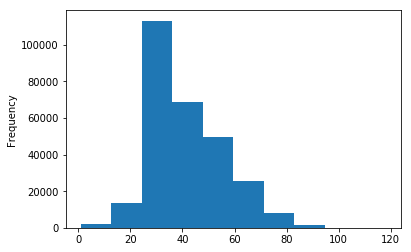

In [150]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

### Look up

In [245]:
tdf = initial_pre(pd.concat([pd.read_csv(TEST_PATH), pd.read_csv(TESTF_PATH, index_col=0)], axis=1))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,pos,neg,pos_w,neg_w
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN,0.0,0.0,0.0,0.0
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN,0.0,0.0,0.0,0.0
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...,0.0,0.0,0.0,0.0
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN,0.0,0.0,0.0,0.0


In [152]:
tdf.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
count,100000,100000,100000.000000,100000.000000,27475,36484,39282,10710
unique,2750,2718,NaN,NaN,2337,4790,31786,744
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.
freq,4618,4618,NaN,NaN,5807,15593,540,5382
mean,NaN,NaN,42.581630,1.663910,NaN,NaN,NaN,NaN
std,NaN,NaN,32.847483,0.472372,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,32.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,39.000000,2.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN


In [153]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [154]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

### Not in `tdf`

In [155]:
def filter_not_in_test(df, tdf, column):
    df = df.copy()
    in_tdf = set(tdf.loc[:, column])
    return df[df.loc[:, column].isin(in_tdf)].copy()

In [156]:
for column in tqdm_notebook(df.columns):
    if column not in {'revisit', 'anamnesis'}:
        df = filter_not_in_test(df, tdf, column)
        print('after', column, df.shape)
df.shape

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

after diag_code (280470, 9)
after diag (280470, 9)
after age (280456, 9)
after sex (280456, 9)
after state (278242, 9)
after allergies (274857, 9)
after checkup (274572, 9)



(274572, 9)

### Strings fuzzy matching

In [157]:
def group_column(df, tdf, column):
    df, tdf = df.copy(), tdf.copy()
    columnv = pd.concat([df[column], tdf[column]])
    cvc = columnv.value_counts()
    bins = []
    for s, c in tqdm_notebook(cvc.iteritems()):
        max_id, max_score = None, None
        for id_, bin_ in enumerate(bins):
            cur_score = fuzz.ratio(s, bin_[0])
            if max_score is None or cur_score > max_score:
                max_id = id_
                max_score = cur_score
        if max_id is not None and max_score > 75:
            bins[max_id].append(s)
        else:
            bins.append([s])
    remap_dict = {}
    for bin_ in bins:
        base = bin_[0]
        for v in bin_:
            remap_dict[v] = base
    df[column] = df[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    tdf[column] = tdf[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    return df, tdf

In [158]:
# SIMILAR_TEXT_COLUMNS = ['state', 'allergies', 'checkup']
# for column in tqdm_notebook(SIMILAR_TEXT_COLUMNS):
#     df, tdf = group_column(df, tdf, column)
# df.shape, tdf.shape

## Preprocess

In [159]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode

In [277]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._encs = None
    
    def fit(self, df):
        return self
    
    def transform(self, df, tdf=None):
        df = df.copy()
    
        features = []
        
        # `diag_code`
        def to_str(x):
            if x is None:
                return ''
            else:
                return str(x)
        
        def pparse(x):
            l, c, s = x
            c = to_str(l) + to_str(c)
            if not c:
                c = None
            return (l, c)
        
        parts = list(df.diag_code \
                     .apply(parse_diag_code) \
                     .apply(pparse))
        features.append(pd.DataFrame(parts, 
                                     columns=['letter', 'code', 'subcode'][:2],
                                     dtype=object, index=df.index))

        # `age`
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
#         df.age = df.age.astype(str)  # => To cat
        features.append(df[['age']])

        # `sex`
        features.append(df[['sex']])

        # `state`
        def state_map(s):
            if 'удовлетворительн' in str(s).lower():
                return True
            else:
                return False
            
        features.append(pd.DataFrame(df.state.apply(state_map).astype(int),
                                     columns=['state'],
                                     index=df.index, dtype=int))
        
        # `diag`, `allergies`, `checkup`
        features.append(df[['allergies', 'checkup']])
        
        
        # anamnesis
        features.append(get_features(df.anamnesis, df.index))
        features.append(pd.DataFrame(df.anamnesis.isnull().as_matrix().astype(int), 
                                     columns=['anamnesis_null'],
                                     index=df.index))
        
        # sentiment features
        features.append(df[['pos', 'neg', 'pos_w', 'neg_w']])

        data = pd.concat(features, axis=1)
        
        # object => int
#         data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        objs = data.dtypes[data.dtypes == object].index.tolist()
        if self._encs is None:
            self._encs = [LabelEncoder().fit(pd.concat([data[obj].fillna('NaN'), 
                                                        pd.Series('NaN')], axis=0)) for obj in objs]
        for obj, enc in zip(objs, self._encs):
            data.loc[~data[obj].isin(enc.classes_), obj] = np.nan
            data[obj] = enc.transform(data[obj].fillna('NaN'))
        
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [278]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,age,sex,state,allergies,checkup,count_nums,exclamation,larger_than_three,not_stop_words,number_words,punct,stop_words,string_len,anamnesis_null,pos,neg,pos_w,neg_w
0,9,451,29.0,2,0,266,267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,13,714,45.0,2,0,266,163,0.0,0.0,30.0,30.0,42.0,4.0,12.0,302.0,0,0.0,0.0,0.0,0.0
2,11,530,63.0,2,0,266,163,1.0,0.0,10.0,11.0,14.0,5.0,3.0,99.0,0,0.0,0.0,0.0,0.0
3,13,697,43.0,2,0,3849,163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,25,1003,29.0,1,0,266,163,0.0,0.0,5.0,5.0,6.0,0.0,1.0,52.0,0,0.0,0.0,0.0,0.0


In [279]:
X.dtypes

letter                 int64
code                   int64
age                  float64
sex                    int64
state                  int64
allergies              int64
checkup                int64
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
pos                  float64
neg                  float64
pos_w                float64
neg_w                float64
dtype: object

In [280]:
y.dtype

dtype('int64')

## TT split

In [281]:
def downsampling(X, y):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    sampled_ids1 = y[y == 1].sample(len(ids0)).index
    nX = pd.concat([X.loc[ids0], X.loc[sampled_ids1]], axis=0)
    ny = pd.concat([y[ids0], y[sampled_ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny


def upsampling(X, y, max_cnt=10000):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    n = min(len(ids1), max_cnt)
    sampled_ids0 = y[y == 0].sample(n, replace=True).index
    index = np.arange(y.index.max() + 1, y.index.max() + n + 1)
    nX = X.loc[sampled_ids0]
    nX.index = index
    nX = pd.concat([nX, X.loc[ids1]], axis=0)
    ny = pd.concat([pd.Series(y[sampled_ids0].as_matrix(), index=index), y[ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny

In [282]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
# X_train, y_train = upsampling(X_train, y_train)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((268931, 20), (14155, 20), (100000, 20))

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

### Run

In [308]:
N_MODELS = 5

In [309]:
models = [cb.CatBoostClassifier(depth=8, eval_metric='AUC', random_seed=42,
                                iterations=2000, od_type='Iter', od_wait=300) 
          for _ in range(N_MODELS)]

In [310]:
def get_stack_score(X):
    return np.vstack((model.predict_proba(X)[:, 1] for model in models)).mean(axis=0)


def get_f_im():
    return np.vstack((model.feature_importances_ for model in models)).mean(axis=0)

In [320]:
X.dtypes

letter                 int64
code                   int64
age                  float64
sex                    int64
state                  int64
allergies              int64
checkup                int64
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
pos                  float64
neg                  float64
pos_w                float64
neg_w                float64
dtype: object

In [311]:
for i, model in enumerate(models):
    print(f'ITERATION NUMBER {i}')
    X_train, X_val, y_train, y_val = train_test_split(*downsampling(X, y), test_size=0.1)
    model.fit(X_train, y_train, cat_features=cat_features, 
              use_best_model=True, eval_set=(X_val, y_val), 
              plot=False);

ITERATION NUMBER 0
0:	learn: 0.6975321	test: 0.7026066	best: 0.7026066 (0)	total: 116ms	remaining: 3m 52s
1:	learn: 0.6978488	test: 0.7022197	best: 0.7026066 (0)	total: 242ms	remaining: 4m 1s
2:	learn: 0.6978280	test: 0.7024993	best: 0.7026066 (0)	total: 354ms	remaining: 3m 55s
3:	learn: 0.6977777	test: 0.7025352	best: 0.7026066 (0)	total: 524ms	remaining: 4m 21s
4:	learn: 0.6977133	test: 0.7026443	best: 0.7026443 (4)	total: 686ms	remaining: 4m 33s
5:	learn: 0.6982788	test: 0.7024546	best: 0.7026443 (4)	total: 880ms	remaining: 4m 52s
6:	learn: 0.6984550	test: 0.7028377	best: 0.7028377 (6)	total: 1.06s	remaining: 5m 2s
7:	learn: 0.6989207	test: 0.7031119	best: 0.7031119 (7)	total: 1.18s	remaining: 4m 53s
8:	learn: 0.6989440	test: 0.7032326	best: 0.7032326 (8)	total: 1.28s	remaining: 4m 44s
9:	learn: 0.6992537	test: 0.7034845	best: 0.7034845 (9)	total: 1.4s	remaining: 4m 38s
10:	learn: 0.6991842	test: 0.7037290	best: 0.7037290 (10)	total: 1.55s	remaining: 4m 40s
11:	learn: 0.6996603	test

93:	learn: 0.7175544	test: 0.7138493	best: 0.7138493 (93)	total: 14.5s	remaining: 4m 53s
94:	learn: 0.7176888	test: 0.7138521	best: 0.7138521 (94)	total: 14.7s	remaining: 4m 54s
95:	learn: 0.7177839	test: 0.7138734	best: 0.7138734 (95)	total: 14.9s	remaining: 4m 54s
96:	learn: 0.7180961	test: 0.7140083	best: 0.7140083 (96)	total: 15s	remaining: 4m 54s
97:	learn: 0.7182545	test: 0.7139826	best: 0.7140083 (96)	total: 15.1s	remaining: 4m 53s
98:	learn: 0.7183775	test: 0.7140033	best: 0.7140083 (96)	total: 15.3s	remaining: 4m 53s
99:	learn: 0.7184414	test: 0.7140238	best: 0.7140238 (99)	total: 15.4s	remaining: 4m 53s
100:	learn: 0.7187186	test: 0.7142389	best: 0.7142389 (100)	total: 15.7s	remaining: 4m 54s
101:	learn: 0.7189022	test: 0.7142594	best: 0.7142594 (101)	total: 15.9s	remaining: 4m 55s
102:	learn: 0.7189504	test: 0.7142958	best: 0.7142958 (102)	total: 16s	remaining: 4m 55s
103:	learn: 0.7190135	test: 0.7142726	best: 0.7142958 (102)	total: 16.1s	remaining: 4m 54s
104:	learn: 0.719

184:	learn: 0.7263882	test: 0.7155699	best: 0.7156262 (182)	total: 29.3s	remaining: 4m 47s
185:	learn: 0.7264675	test: 0.7156021	best: 0.7156262 (182)	total: 29.5s	remaining: 4m 47s
186:	learn: 0.7265421	test: 0.7155951	best: 0.7156262 (182)	total: 29.6s	remaining: 4m 47s
187:	learn: 0.7265963	test: 0.7155859	best: 0.7156262 (182)	total: 29.7s	remaining: 4m 46s
188:	learn: 0.7266370	test: 0.7155842	best: 0.7156262 (182)	total: 29.9s	remaining: 4m 46s
189:	learn: 0.7267148	test: 0.7155687	best: 0.7156262 (182)	total: 30s	remaining: 4m 46s
190:	learn: 0.7268003	test: 0.7155875	best: 0.7156262 (182)	total: 30.2s	remaining: 4m 46s
191:	learn: 0.7268932	test: 0.7155621	best: 0.7156262 (182)	total: 30.5s	remaining: 4m 46s
192:	learn: 0.7269574	test: 0.7155557	best: 0.7156262 (182)	total: 30.6s	remaining: 4m 46s
193:	learn: 0.7270737	test: 0.7156359	best: 0.7156359 (193)	total: 30.7s	remaining: 4m 46s
194:	learn: 0.7271535	test: 0.7156131	best: 0.7156359 (193)	total: 30.9s	remaining: 4m 45s
1

275:	learn: 0.7326694	test: 0.7157517	best: 0.7157798 (271)	total: 44.4s	remaining: 4m 37s
276:	learn: 0.7327723	test: 0.7157280	best: 0.7157798 (271)	total: 44.5s	remaining: 4m 36s
277:	learn: 0.7328072	test: 0.7157336	best: 0.7157798 (271)	total: 44.7s	remaining: 4m 36s
278:	learn: 0.7329006	test: 0.7157666	best: 0.7157798 (271)	total: 44.9s	remaining: 4m 36s
279:	learn: 0.7329905	test: 0.7157985	best: 0.7157985 (279)	total: 45.1s	remaining: 4m 37s
280:	learn: 0.7330404	test: 0.7158113	best: 0.7158113 (280)	total: 45.3s	remaining: 4m 37s
281:	learn: 0.7331438	test: 0.7158163	best: 0.7158163 (281)	total: 45.4s	remaining: 4m 36s
282:	learn: 0.7331959	test: 0.7158252	best: 0.7158252 (282)	total: 45.6s	remaining: 4m 36s
283:	learn: 0.7332503	test: 0.7158245	best: 0.7158252 (282)	total: 45.7s	remaining: 4m 36s
284:	learn: 0.7333199	test: 0.7158287	best: 0.7158287 (284)	total: 45.9s	remaining: 4m 36s
285:	learn: 0.7333971	test: 0.7158554	best: 0.7158554 (285)	total: 46.2s	remaining: 4m 36s

366:	learn: 0.7379964	test: 0.7163842	best: 0.7164113 (361)	total: 59.5s	remaining: 4m 24s
367:	learn: 0.7380790	test: 0.7164060	best: 0.7164113 (361)	total: 59.7s	remaining: 4m 24s
368:	learn: 0.7381232	test: 0.7164103	best: 0.7164113 (361)	total: 59.8s	remaining: 4m 24s
369:	learn: 0.7381723	test: 0.7163948	best: 0.7164113 (361)	total: 60s	remaining: 4m 24s
370:	learn: 0.7382186	test: 0.7164059	best: 0.7164113 (361)	total: 1m	remaining: 4m 24s
371:	learn: 0.7382480	test: 0.7164220	best: 0.7164220 (371)	total: 1m	remaining: 4m 23s
372:	learn: 0.7383208	test: 0.7164158	best: 0.7164220 (371)	total: 1m	remaining: 4m 24s
373:	learn: 0.7383978	test: 0.7164568	best: 0.7164568 (373)	total: 1m	remaining: 4m 23s
374:	learn: 0.7385168	test: 0.7164683	best: 0.7164683 (374)	total: 1m	remaining: 4m 23s
375:	learn: 0.7386033	test: 0.7164345	best: 0.7164683 (374)	total: 1m	remaining: 4m 23s
376:	learn: 0.7386784	test: 0.7164254	best: 0.7164683 (374)	total: 1m 1s	remaining: 4m 23s
377:	learn: 0.73871

456:	learn: 0.7440467	test: 0.7167451	best: 0.7167484 (454)	total: 1m 14s	remaining: 4m 12s
457:	learn: 0.7441197	test: 0.7167446	best: 0.7167484 (454)	total: 1m 14s	remaining: 4m 11s
458:	learn: 0.7442107	test: 0.7167515	best: 0.7167515 (458)	total: 1m 14s	remaining: 4m 11s
459:	learn: 0.7442638	test: 0.7167488	best: 0.7167515 (458)	total: 1m 15s	remaining: 4m 11s
460:	learn: 0.7442907	test: 0.7167487	best: 0.7167515 (458)	total: 1m 15s	remaining: 4m 10s
461:	learn: 0.7443248	test: 0.7167637	best: 0.7167637 (461)	total: 1m 15s	remaining: 4m 10s
462:	learn: 0.7443903	test: 0.7168028	best: 0.7168028 (462)	total: 1m 15s	remaining: 4m 10s
463:	learn: 0.7444492	test: 0.7168211	best: 0.7168211 (463)	total: 1m 15s	remaining: 4m 9s
464:	learn: 0.7445548	test: 0.7168138	best: 0.7168211 (463)	total: 1m 15s	remaining: 4m 9s
465:	learn: 0.7445834	test: 0.7168018	best: 0.7168211 (463)	total: 1m 15s	remaining: 4m 9s
466:	learn: 0.7446401	test: 0.7168003	best: 0.7168211 (463)	total: 1m 15s	remaining

546:	learn: 0.7495442	test: 0.7168070	best: 0.7169555 (519)	total: 1m 25s	remaining: 3m 47s
547:	learn: 0.7496262	test: 0.7167940	best: 0.7169555 (519)	total: 1m 25s	remaining: 3m 47s
548:	learn: 0.7496920	test: 0.7168119	best: 0.7169555 (519)	total: 1m 25s	remaining: 3m 47s
549:	learn: 0.7497956	test: 0.7168040	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 47s
550:	learn: 0.7498481	test: 0.7168177	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 46s
551:	learn: 0.7499131	test: 0.7168268	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 46s
552:	learn: 0.7499857	test: 0.7168338	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 46s
553:	learn: 0.7500291	test: 0.7168379	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 45s
554:	learn: 0.7500993	test: 0.7168402	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 45s
555:	learn: 0.7502032	test: 0.7168514	best: 0.7169555 (519)	total: 1m 26s	remaining: 3m 45s
556:	learn: 0.7502473	test: 0.7168471	best: 0.7169555 (519)	total: 1m 26s	remain

636:	learn: 0.7546888	test: 0.7171008	best: 0.7171008 (636)	total: 1m 36s	remaining: 3m 26s
637:	learn: 0.7547301	test: 0.7171056	best: 0.7171056 (637)	total: 1m 36s	remaining: 3m 26s
638:	learn: 0.7547739	test: 0.7171196	best: 0.7171196 (638)	total: 1m 36s	remaining: 3m 26s
639:	learn: 0.7548967	test: 0.7171101	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 26s
640:	learn: 0.7549096	test: 0.7171096	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 26s
641:	learn: 0.7549341	test: 0.7171073	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 25s
642:	learn: 0.7550422	test: 0.7170793	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 25s
643:	learn: 0.7550949	test: 0.7170716	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 25s
644:	learn: 0.7551590	test: 0.7170469	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 25s
645:	learn: 0.7551929	test: 0.7170345	best: 0.7171196 (638)	total: 1m 37s	remaining: 3m 25s
646:	learn: 0.7552125	test: 0.7170379	best: 0.7171196 (638)	total: 1m 37s	remain

726:	learn: 0.7597290	test: 0.7169319	best: 0.7171196 (638)	total: 1m 47s	remaining: 3m 8s
727:	learn: 0.7597727	test: 0.7169476	best: 0.7171196 (638)	total: 1m 47s	remaining: 3m 8s
728:	learn: 0.7598170	test: 0.7169606	best: 0.7171196 (638)	total: 1m 47s	remaining: 3m 8s
729:	learn: 0.7598861	test: 0.7169359	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 7s
730:	learn: 0.7599095	test: 0.7169316	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 7s
731:	learn: 0.7599606	test: 0.7169419	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 7s
732:	learn: 0.7600608	test: 0.7169172	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 7s
733:	learn: 0.7600983	test: 0.7169282	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 7s
734:	learn: 0.7601297	test: 0.7169207	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 6s
735:	learn: 0.7601740	test: 0.7168960	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 6s
736:	learn: 0.7601937	test: 0.7169089	best: 0.7171196 (638)	total: 1m 48s	remaining: 3m 6s

816:	learn: 0.7650158	test: 0.7163817	best: 0.7171196 (638)	total: 1m 58s	remaining: 2m 51s
817:	learn: 0.7651230	test: 0.7163910	best: 0.7171196 (638)	total: 1m 58s	remaining: 2m 51s
818:	learn: 0.7651555	test: 0.7163875	best: 0.7171196 (638)	total: 1m 58s	remaining: 2m 51s
819:	learn: 0.7652533	test: 0.7163226	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 51s
820:	learn: 0.7652787	test: 0.7163337	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 51s
821:	learn: 0.7653592	test: 0.7163209	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 50s
822:	learn: 0.7653718	test: 0.7163447	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 50s
823:	learn: 0.7654177	test: 0.7163447	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 50s
824:	learn: 0.7654672	test: 0.7163499	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 50s
825:	learn: 0.7654800	test: 0.7163579	best: 0.7171196 (638)	total: 1m 59s	remaining: 2m 50s
826:	learn: 0.7655458	test: 0.7163847	best: 0.7171196 (638)	total: 1m 59s	remain

907:	learn: 0.7698674	test: 0.7163153	best: 0.7171196 (638)	total: 2m 11s	remaining: 2m 38s
908:	learn: 0.7699059	test: 0.7163114	best: 0.7171196 (638)	total: 2m 12s	remaining: 2m 38s
909:	learn: 0.7699804	test: 0.7163315	best: 0.7171196 (638)	total: 2m 12s	remaining: 2m 38s
910:	learn: 0.7700590	test: 0.7163392	best: 0.7171196 (638)	total: 2m 12s	remaining: 2m 38s
911:	learn: 0.7701298	test: 0.7163246	best: 0.7171196 (638)	total: 2m 12s	remaining: 2m 38s
912:	learn: 0.7701599	test: 0.7163493	best: 0.7171196 (638)	total: 2m 12s	remaining: 2m 38s
913:	learn: 0.7701934	test: 0.7163341	best: 0.7171196 (638)	total: 2m 12s	remaining: 2m 37s
914:	learn: 0.7702260	test: 0.7163195	best: 0.7171196 (638)	total: 2m 13s	remaining: 2m 37s
915:	learn: 0.7703073	test: 0.7163441	best: 0.7171196 (638)	total: 2m 13s	remaining: 2m 37s
916:	learn: 0.7703261	test: 0.7163534	best: 0.7171196 (638)	total: 2m 13s	remaining: 2m 37s
917:	learn: 0.7704021	test: 0.7163177	best: 0.7171196 (638)	total: 2m 13s	remain

58:	learn: 0.7137112	test: 0.7113138	best: 0.7113138 (58)	total: 8.87s	remaining: 4m 51s
59:	learn: 0.7137706	test: 0.7113278	best: 0.7113278 (59)	total: 8.99s	remaining: 4m 50s
60:	learn: 0.7139161	test: 0.7114152	best: 0.7114152 (60)	total: 9.19s	remaining: 4m 52s
61:	learn: 0.7140305	test: 0.7114630	best: 0.7114630 (61)	total: 9.4s	remaining: 4m 53s
62:	learn: 0.7141094	test: 0.7114744	best: 0.7114744 (62)	total: 9.55s	remaining: 4m 53s
63:	learn: 0.7142915	test: 0.7115022	best: 0.7115022 (63)	total: 9.68s	remaining: 4m 52s
64:	learn: 0.7144849	test: 0.7116118	best: 0.7116118 (64)	total: 9.83s	remaining: 4m 52s
65:	learn: 0.7145728	test: 0.7117038	best: 0.7117038 (65)	total: 9.99s	remaining: 4m 52s
66:	learn: 0.7146198	test: 0.7117371	best: 0.7117371 (66)	total: 10.2s	remaining: 4m 54s
67:	learn: 0.7147548	test: 0.7119225	best: 0.7119225 (67)	total: 10.4s	remaining: 4m 55s
68:	learn: 0.7148739	test: 0.7119899	best: 0.7119899 (68)	total: 10.6s	remaining: 4m 55s
69:	learn: 0.7149718	t

150:	learn: 0.7236987	test: 0.7152615	best: 0.7152615 (150)	total: 24s	remaining: 4m 54s
151:	learn: 0.7238304	test: 0.7152968	best: 0.7152968 (151)	total: 24.2s	remaining: 4m 53s
152:	learn: 0.7239033	test: 0.7153275	best: 0.7153275 (152)	total: 24.3s	remaining: 4m 53s
153:	learn: 0.7239558	test: 0.7153606	best: 0.7153606 (153)	total: 24.5s	remaining: 4m 53s
154:	learn: 0.7240643	test: 0.7153245	best: 0.7153606 (153)	total: 24.7s	remaining: 4m 53s
155:	learn: 0.7242306	test: 0.7153547	best: 0.7153606 (153)	total: 24.9s	remaining: 4m 54s
156:	learn: 0.7242686	test: 0.7153398	best: 0.7153606 (153)	total: 25s	remaining: 4m 53s
157:	learn: 0.7243786	test: 0.7153366	best: 0.7153606 (153)	total: 25.2s	remaining: 4m 53s
158:	learn: 0.7244543	test: 0.7153576	best: 0.7153606 (153)	total: 25.3s	remaining: 4m 52s
159:	learn: 0.7245068	test: 0.7153461	best: 0.7153606 (153)	total: 25.4s	remaining: 4m 52s
160:	learn: 0.7245629	test: 0.7153624	best: 0.7153624 (160)	total: 25.6s	remaining: 4m 52s
161

241:	learn: 0.7308253	test: 0.7156397	best: 0.7156397 (241)	total: 39s	remaining: 4m 43s
242:	learn: 0.7309330	test: 0.7155981	best: 0.7156397 (241)	total: 39.2s	remaining: 4m 43s
243:	learn: 0.7309768	test: 0.7156008	best: 0.7156397 (241)	total: 39.4s	remaining: 4m 43s
244:	learn: 0.7310230	test: 0.7156567	best: 0.7156567 (244)	total: 39.6s	remaining: 4m 43s
245:	learn: 0.7310835	test: 0.7156660	best: 0.7156660 (245)	total: 39.7s	remaining: 4m 42s
246:	learn: 0.7311324	test: 0.7156757	best: 0.7156757 (246)	total: 39.8s	remaining: 4m 42s
247:	learn: 0.7311794	test: 0.7157047	best: 0.7157047 (247)	total: 40.1s	remaining: 4m 42s
248:	learn: 0.7312291	test: 0.7157543	best: 0.7157543 (248)	total: 40.3s	remaining: 4m 43s
249:	learn: 0.7312591	test: 0.7157587	best: 0.7157587 (249)	total: 40.4s	remaining: 4m 43s
250:	learn: 0.7313401	test: 0.7157238	best: 0.7157587 (249)	total: 40.6s	remaining: 4m 42s
251:	learn: 0.7314483	test: 0.7157285	best: 0.7157587 (249)	total: 40.7s	remaining: 4m 42s
2

332:	learn: 0.7371692	test: 0.7156753	best: 0.7159368 (295)	total: 53.9s	remaining: 4m 29s
333:	learn: 0.7372667	test: 0.7156575	best: 0.7159368 (295)	total: 54.1s	remaining: 4m 29s
334:	learn: 0.7373104	test: 0.7156537	best: 0.7159368 (295)	total: 54.2s	remaining: 4m 29s
335:	learn: 0.7374083	test: 0.7156417	best: 0.7159368 (295)	total: 54.4s	remaining: 4m 29s
336:	learn: 0.7374878	test: 0.7156189	best: 0.7159368 (295)	total: 54.6s	remaining: 4m 29s
337:	learn: 0.7375396	test: 0.7156265	best: 0.7159368 (295)	total: 54.8s	remaining: 4m 29s
338:	learn: 0.7376106	test: 0.7156403	best: 0.7159368 (295)	total: 54.9s	remaining: 4m 29s
339:	learn: 0.7376878	test: 0.7156063	best: 0.7159368 (295)	total: 55.1s	remaining: 4m 28s
340:	learn: 0.7377469	test: 0.7155774	best: 0.7159368 (295)	total: 55.2s	remaining: 4m 28s
341:	learn: 0.7378098	test: 0.7155444	best: 0.7159368 (295)	total: 55.4s	remaining: 4m 28s
342:	learn: 0.7378582	test: 0.7155507	best: 0.7159368 (295)	total: 55.7s	remaining: 4m 28s

424:	learn: 0.7437236	test: 0.7158383	best: 0.7159368 (295)	total: 1m 9s	remaining: 4m 16s
425:	learn: 0.7437752	test: 0.7158321	best: 0.7159368 (295)	total: 1m 9s	remaining: 4m 16s
426:	learn: 0.7438527	test: 0.7158433	best: 0.7159368 (295)	total: 1m 9s	remaining: 4m 15s
427:	learn: 0.7439184	test: 0.7158250	best: 0.7159368 (295)	total: 1m 9s	remaining: 4m 15s
428:	learn: 0.7440302	test: 0.7158450	best: 0.7159368 (295)	total: 1m 9s	remaining: 4m 15s
429:	learn: 0.7441207	test: 0.7158441	best: 0.7159368 (295)	total: 1m 10s	remaining: 4m 15s
430:	learn: 0.7441753	test: 0.7158563	best: 0.7159368 (295)	total: 1m 10s	remaining: 4m 15s
431:	learn: 0.7442238	test: 0.7158580	best: 0.7159368 (295)	total: 1m 10s	remaining: 4m 15s
432:	learn: 0.7443089	test: 0.7158759	best: 0.7159368 (295)	total: 1m 10s	remaining: 4m 15s
433:	learn: 0.7443459	test: 0.7158747	best: 0.7159368 (295)	total: 1m 10s	remaining: 4m 14s
434:	learn: 0.7444594	test: 0.7159053	best: 0.7159368 (295)	total: 1m 10s	remaining: 

515:	learn: 0.7496439	test: 0.7159867	best: 0.7159867 (515)	total: 1m 24s	remaining: 4m 2s
516:	learn: 0.7496661	test: 0.7159838	best: 0.7159867 (515)	total: 1m 24s	remaining: 4m 1s
517:	learn: 0.7497472	test: 0.7159977	best: 0.7159977 (517)	total: 1m 24s	remaining: 4m 1s
518:	learn: 0.7498165	test: 0.7160123	best: 0.7160123 (518)	total: 1m 24s	remaining: 4m 1s
519:	learn: 0.7498564	test: 0.7160203	best: 0.7160203 (519)	total: 1m 24s	remaining: 4m 1s
520:	learn: 0.7499519	test: 0.7160075	best: 0.7160203 (519)	total: 1m 25s	remaining: 4m 1s
521:	learn: 0.7500327	test: 0.7159965	best: 0.7160203 (519)	total: 1m 25s	remaining: 4m 1s
522:	learn: 0.7500726	test: 0.7160238	best: 0.7160238 (522)	total: 1m 25s	remaining: 4m 1s
523:	learn: 0.7501154	test: 0.7160140	best: 0.7160238 (522)	total: 1m 25s	remaining: 4m
524:	learn: 0.7501433	test: 0.7160193	best: 0.7160238 (522)	total: 1m 25s	remaining: 4m
525:	learn: 0.7502297	test: 0.7160228	best: 0.7160238 (522)	total: 1m 25s	remaining: 4m
526:	lea

606:	learn: 0.7547326	test: 0.7158660	best: 0.7161378 (562)	total: 1m 39s	remaining: 3m 48s
607:	learn: 0.7547833	test: 0.7158641	best: 0.7161378 (562)	total: 1m 39s	remaining: 3m 48s
608:	learn: 0.7548169	test: 0.7158620	best: 0.7161378 (562)	total: 1m 39s	remaining: 3m 48s
609:	learn: 0.7548843	test: 0.7158742	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 47s
610:	learn: 0.7549712	test: 0.7158550	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 47s
611:	learn: 0.7550273	test: 0.7158195	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 47s
612:	learn: 0.7550805	test: 0.7158200	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 47s
613:	learn: 0.7552072	test: 0.7158183	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 47s
614:	learn: 0.7552464	test: 0.7158160	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 47s
615:	learn: 0.7552619	test: 0.7158302	best: 0.7161378 (562)	total: 1m 40s	remaining: 3m 46s
616:	learn: 0.7553387	test: 0.7158323	best: 0.7161378 (562)	total: 1m 41s	remain

696:	learn: 0.7594891	test: 0.7156053	best: 0.7161378 (562)	total: 1m 54s	remaining: 3m 33s
697:	learn: 0.7595604	test: 0.7156255	best: 0.7161378 (562)	total: 1m 54s	remaining: 3m 33s
698:	learn: 0.7595795	test: 0.7156376	best: 0.7161378 (562)	total: 1m 54s	remaining: 3m 33s
699:	learn: 0.7596649	test: 0.7156267	best: 0.7161378 (562)	total: 1m 54s	remaining: 3m 33s
700:	learn: 0.7596901	test: 0.7156447	best: 0.7161378 (562)	total: 1m 54s	remaining: 3m 33s
701:	learn: 0.7597609	test: 0.7156448	best: 0.7161378 (562)	total: 1m 55s	remaining: 3m 32s
702:	learn: 0.7598676	test: 0.7156227	best: 0.7161378 (562)	total: 1m 55s	remaining: 3m 32s
703:	learn: 0.7599051	test: 0.7156264	best: 0.7161378 (562)	total: 1m 55s	remaining: 3m 32s
704:	learn: 0.7600096	test: 0.7156316	best: 0.7161378 (562)	total: 1m 55s	remaining: 3m 32s
705:	learn: 0.7600700	test: 0.7156135	best: 0.7161378 (562)	total: 1m 55s	remaining: 3m 32s
706:	learn: 0.7601388	test: 0.7156045	best: 0.7161378 (562)	total: 1m 56s	remain

787:	learn: 0.7647866	test: 0.7154930	best: 0.7161378 (562)	total: 2m 9s	remaining: 3m 19s
788:	learn: 0.7648924	test: 0.7154569	best: 0.7161378 (562)	total: 2m 9s	remaining: 3m 19s
789:	learn: 0.7649625	test: 0.7154333	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 19s
790:	learn: 0.7650243	test: 0.7154481	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 18s
791:	learn: 0.7650924	test: 0.7154606	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 18s
792:	learn: 0.7651518	test: 0.7154815	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 18s
793:	learn: 0.7651857	test: 0.7154545	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 18s
794:	learn: 0.7652413	test: 0.7154268	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 18s
795:	learn: 0.7653097	test: 0.7154372	best: 0.7161378 (562)	total: 2m 10s	remaining: 3m 18s
796:	learn: 0.7653873	test: 0.7153979	best: 0.7161378 (562)	total: 2m 11s	remaining: 3m 17s
797:	learn: 0.7654551	test: 0.7153643	best: 0.7161378 (562)	total: 2m 11s	remainin

12:	learn: 0.6976475	test: 0.6963141	best: 0.6964256 (10)	total: 1.88s	remaining: 4m 47s
13:	learn: 0.6977984	test: 0.6964520	best: 0.6964520 (13)	total: 2.06s	remaining: 4m 52s
14:	learn: 0.6978492	test: 0.6964532	best: 0.6964532 (14)	total: 2.2s	remaining: 4m 51s
15:	learn: 0.6979150	test: 0.6966640	best: 0.6966640 (15)	total: 2.31s	remaining: 4m 46s
16:	learn: 0.6979239	test: 0.6966178	best: 0.6966640 (15)	total: 2.43s	remaining: 4m 44s
17:	learn: 0.6980313	test: 0.6968818	best: 0.6968818 (17)	total: 2.57s	remaining: 4m 42s
18:	learn: 0.6980182	test: 0.6969277	best: 0.6969277 (18)	total: 2.74s	remaining: 4m 45s
19:	learn: 0.6980680	test: 0.6969096	best: 0.6969277 (18)	total: 2.93s	remaining: 4m 50s
20:	learn: 0.6980593	test: 0.6969320	best: 0.6969320 (20)	total: 3.12s	remaining: 4m 54s
21:	learn: 0.6999923	test: 0.6991160	best: 0.6991160 (21)	total: 3.26s	remaining: 4m 52s
22:	learn: 0.7013595	test: 0.7005969	best: 0.7005969 (22)	total: 3.37s	remaining: 4m 49s
23:	learn: 0.7021899	t

106:	learn: 0.7176900	test: 0.7122612	best: 0.7122612 (106)	total: 16.6s	remaining: 4m 54s
107:	learn: 0.7178373	test: 0.7124492	best: 0.7124492 (107)	total: 16.7s	remaining: 4m 53s
108:	learn: 0.7179376	test: 0.7124364	best: 0.7124492 (107)	total: 16.9s	remaining: 4m 53s
109:	learn: 0.7180473	test: 0.7123995	best: 0.7124492 (107)	total: 17.1s	remaining: 4m 53s
110:	learn: 0.7181256	test: 0.7124706	best: 0.7124706 (110)	total: 17.3s	remaining: 4m 54s
111:	learn: 0.7181876	test: 0.7124983	best: 0.7124983 (111)	total: 17.5s	remaining: 4m 55s
112:	learn: 0.7182796	test: 0.7124705	best: 0.7124983 (111)	total: 17.6s	remaining: 4m 54s
113:	learn: 0.7183227	test: 0.7124963	best: 0.7124983 (111)	total: 17.8s	remaining: 4m 54s
114:	learn: 0.7184561	test: 0.7125062	best: 0.7125062 (114)	total: 18s	remaining: 4m 54s
115:	learn: 0.7185381	test: 0.7125294	best: 0.7125294 (115)	total: 18.2s	remaining: 4m 55s
116:	learn: 0.7185613	test: 0.7125240	best: 0.7125294 (115)	total: 18.4s	remaining: 4m 55s
1

197:	learn: 0.7249679	test: 0.7136941	best: 0.7137240 (196)	total: 31.9s	remaining: 4m 50s
198:	learn: 0.7251187	test: 0.7136687	best: 0.7137240 (196)	total: 32s	remaining: 4m 49s
199:	learn: 0.7252284	test: 0.7136941	best: 0.7137240 (196)	total: 32.2s	remaining: 4m 49s
200:	learn: 0.7253243	test: 0.7136632	best: 0.7137240 (196)	total: 32.3s	remaining: 4m 49s
201:	learn: 0.7253787	test: 0.7137014	best: 0.7137240 (196)	total: 32.5s	remaining: 4m 48s
202:	learn: 0.7255017	test: 0.7136952	best: 0.7137240 (196)	total: 32.7s	remaining: 4m 49s
203:	learn: 0.7255736	test: 0.7136929	best: 0.7137240 (196)	total: 32.9s	remaining: 4m 49s
204:	learn: 0.7256598	test: 0.7137148	best: 0.7137240 (196)	total: 33s	remaining: 4m 49s
205:	learn: 0.7256858	test: 0.7137118	best: 0.7137240 (196)	total: 33.2s	remaining: 4m 48s
206:	learn: 0.7257259	test: 0.7137130	best: 0.7137240 (196)	total: 33.3s	remaining: 4m 48s
207:	learn: 0.7257931	test: 0.7137300	best: 0.7137300 (207)	total: 33.5s	remaining: 4m 48s
208

288:	learn: 0.7316538	test: 0.7145341	best: 0.7145341 (288)	total: 47.1s	remaining: 4m 38s
289:	learn: 0.7317274	test: 0.7145132	best: 0.7145341 (288)	total: 47.3s	remaining: 4m 38s
290:	learn: 0.7317876	test: 0.7145044	best: 0.7145341 (288)	total: 47.5s	remaining: 4m 38s
291:	learn: 0.7318109	test: 0.7145126	best: 0.7145341 (288)	total: 47.6s	remaining: 4m 38s
292:	learn: 0.7318871	test: 0.7145217	best: 0.7145341 (288)	total: 47.7s	remaining: 4m 38s
293:	learn: 0.7319999	test: 0.7145201	best: 0.7145341 (288)	total: 47.9s	remaining: 4m 37s
294:	learn: 0.7320431	test: 0.7144954	best: 0.7145341 (288)	total: 48.1s	remaining: 4m 38s
295:	learn: 0.7320582	test: 0.7145036	best: 0.7145341 (288)	total: 48.3s	remaining: 4m 38s
296:	learn: 0.7321194	test: 0.7144990	best: 0.7145341 (288)	total: 48.5s	remaining: 4m 38s
297:	learn: 0.7321743	test: 0.7144850	best: 0.7145341 (288)	total: 48.6s	remaining: 4m 37s
298:	learn: 0.7322445	test: 0.7144801	best: 0.7145341 (288)	total: 48.7s	remaining: 4m 37s

379:	learn: 0.7373141	test: 0.7148312	best: 0.7149844 (361)	total: 1m 2s	remaining: 4m 26s
380:	learn: 0.7373422	test: 0.7148367	best: 0.7149844 (361)	total: 1m 2s	remaining: 4m 26s
381:	learn: 0.7374887	test: 0.7148155	best: 0.7149844 (361)	total: 1m 2s	remaining: 4m 26s
382:	learn: 0.7375236	test: 0.7147995	best: 0.7149844 (361)	total: 1m 2s	remaining: 4m 25s
383:	learn: 0.7375936	test: 0.7148167	best: 0.7149844 (361)	total: 1m 3s	remaining: 4m 25s
384:	learn: 0.7376817	test: 0.7148274	best: 0.7149844 (361)	total: 1m 3s	remaining: 4m 25s
385:	learn: 0.7377513	test: 0.7148235	best: 0.7149844 (361)	total: 1m 3s	remaining: 4m 25s
386:	learn: 0.7377786	test: 0.7148179	best: 0.7149844 (361)	total: 1m 3s	remaining: 4m 25s
387:	learn: 0.7378789	test: 0.7148340	best: 0.7149844 (361)	total: 1m 3s	remaining: 4m 25s
388:	learn: 0.7379589	test: 0.7148495	best: 0.7149844 (361)	total: 1m 3s	remaining: 4m 24s
389:	learn: 0.7380034	test: 0.7148981	best: 0.7149844 (361)	total: 1m 4s	remaining: 4m 24s

469:	learn: 0.7424260	test: 0.7151095	best: 0.7152615 (453)	total: 1m 17s	remaining: 4m 12s
470:	learn: 0.7424752	test: 0.7151624	best: 0.7152615 (453)	total: 1m 17s	remaining: 4m 11s
471:	learn: 0.7425112	test: 0.7151467	best: 0.7152615 (453)	total: 1m 17s	remaining: 4m 11s
472:	learn: 0.7426551	test: 0.7151309	best: 0.7152615 (453)	total: 1m 17s	remaining: 4m 11s
473:	learn: 0.7426693	test: 0.7151229	best: 0.7152615 (453)	total: 1m 18s	remaining: 4m 11s
474:	learn: 0.7427116	test: 0.7151129	best: 0.7152615 (453)	total: 1m 18s	remaining: 4m 11s
475:	learn: 0.7427607	test: 0.7151069	best: 0.7152615 (453)	total: 1m 18s	remaining: 4m 11s
476:	learn: 0.7428645	test: 0.7151163	best: 0.7152615 (453)	total: 1m 18s	remaining: 4m 11s
477:	learn: 0.7429288	test: 0.7151033	best: 0.7152615 (453)	total: 1m 18s	remaining: 4m 10s
478:	learn: 0.7429866	test: 0.7151204	best: 0.7152615 (453)	total: 1m 19s	remaining: 4m 10s
479:	learn: 0.7430388	test: 0.7151498	best: 0.7152615 (453)	total: 1m 19s	remain

560:	learn: 0.7482888	test: 0.7151333	best: 0.7152866 (502)	total: 1m 33s	remaining: 3m 58s
561:	learn: 0.7483879	test: 0.7151333	best: 0.7152866 (502)	total: 1m 33s	remaining: 3m 58s
562:	learn: 0.7484643	test: 0.7151694	best: 0.7152866 (502)	total: 1m 33s	remaining: 3m 58s
563:	learn: 0.7484942	test: 0.7151793	best: 0.7152866 (502)	total: 1m 33s	remaining: 3m 58s
564:	learn: 0.7485434	test: 0.7151836	best: 0.7152866 (502)	total: 1m 33s	remaining: 3m 57s
565:	learn: 0.7485936	test: 0.7151516	best: 0.7152866 (502)	total: 1m 33s	remaining: 3m 57s
566:	learn: 0.7486626	test: 0.7151550	best: 0.7152866 (502)	total: 1m 34s	remaining: 3m 57s
567:	learn: 0.7486916	test: 0.7151781	best: 0.7152866 (502)	total: 1m 34s	remaining: 3m 57s
568:	learn: 0.7487846	test: 0.7151876	best: 0.7152866 (502)	total: 1m 34s	remaining: 3m 57s
569:	learn: 0.7488166	test: 0.7151863	best: 0.7152866 (502)	total: 1m 34s	remaining: 3m 57s
570:	learn: 0.7488557	test: 0.7151799	best: 0.7152866 (502)	total: 1m 34s	remain

651:	learn: 0.7536641	test: 0.7153781	best: 0.7154286 (641)	total: 1m 48s	remaining: 3m 43s
652:	learn: 0.7537239	test: 0.7153869	best: 0.7154286 (641)	total: 1m 48s	remaining: 3m 43s
653:	learn: 0.7537725	test: 0.7153908	best: 0.7154286 (641)	total: 1m 48s	remaining: 3m 43s
654:	learn: 0.7538211	test: 0.7153873	best: 0.7154286 (641)	total: 1m 48s	remaining: 3m 43s
655:	learn: 0.7538808	test: 0.7154006	best: 0.7154286 (641)	total: 1m 49s	remaining: 3m 43s
656:	learn: 0.7540007	test: 0.7154278	best: 0.7154286 (641)	total: 1m 49s	remaining: 3m 43s
657:	learn: 0.7540771	test: 0.7154727	best: 0.7154727 (657)	total: 1m 49s	remaining: 3m 42s
658:	learn: 0.7541552	test: 0.7154874	best: 0.7154874 (658)	total: 1m 49s	remaining: 3m 42s
659:	learn: 0.7541696	test: 0.7155002	best: 0.7155002 (659)	total: 1m 49s	remaining: 3m 42s
660:	learn: 0.7542381	test: 0.7154912	best: 0.7155002 (659)	total: 1m 49s	remaining: 3m 42s
661:	learn: 0.7543045	test: 0.7155163	best: 0.7155163 (661)	total: 1m 50s	remain

741:	learn: 0.7588378	test: 0.7152728	best: 0.7156228 (675)	total: 2m 3s	remaining: 3m 29s
742:	learn: 0.7588713	test: 0.7152813	best: 0.7156228 (675)	total: 2m 3s	remaining: 3m 29s
743:	learn: 0.7589281	test: 0.7152595	best: 0.7156228 (675)	total: 2m 3s	remaining: 3m 29s
744:	learn: 0.7589970	test: 0.7152149	best: 0.7156228 (675)	total: 2m 4s	remaining: 3m 29s
745:	learn: 0.7590315	test: 0.7152050	best: 0.7156228 (675)	total: 2m 4s	remaining: 3m 28s
746:	learn: 0.7590993	test: 0.7152047	best: 0.7156228 (675)	total: 2m 4s	remaining: 3m 28s
747:	learn: 0.7591574	test: 0.7152171	best: 0.7156228 (675)	total: 2m 4s	remaining: 3m 28s
748:	learn: 0.7592123	test: 0.7152178	best: 0.7156228 (675)	total: 2m 4s	remaining: 3m 28s
749:	learn: 0.7593028	test: 0.7152061	best: 0.7156228 (675)	total: 2m 4s	remaining: 3m 28s
750:	learn: 0.7593186	test: 0.7151944	best: 0.7156228 (675)	total: 2m 5s	remaining: 3m 28s
751:	learn: 0.7594091	test: 0.7151795	best: 0.7156228 (675)	total: 2m 5s	remaining: 3m 27s

831:	learn: 0.7639663	test: 0.7148963	best: 0.7156228 (675)	total: 2m 18s	remaining: 3m 14s
832:	learn: 0.7639912	test: 0.7148960	best: 0.7156228 (675)	total: 2m 18s	remaining: 3m 14s
833:	learn: 0.7640834	test: 0.7149343	best: 0.7156228 (675)	total: 2m 18s	remaining: 3m 14s
834:	learn: 0.7641461	test: 0.7149384	best: 0.7156228 (675)	total: 2m 19s	remaining: 3m 13s
835:	learn: 0.7642455	test: 0.7149187	best: 0.7156228 (675)	total: 2m 19s	remaining: 3m 13s
836:	learn: 0.7642869	test: 0.7149167	best: 0.7156228 (675)	total: 2m 19s	remaining: 3m 13s
837:	learn: 0.7643128	test: 0.7149095	best: 0.7156228 (675)	total: 2m 19s	remaining: 3m 13s
838:	learn: 0.7643736	test: 0.7149260	best: 0.7156228 (675)	total: 2m 19s	remaining: 3m 13s
839:	learn: 0.7644734	test: 0.7149197	best: 0.7156228 (675)	total: 2m 19s	remaining: 3m 13s
840:	learn: 0.7645309	test: 0.7148838	best: 0.7156228 (675)	total: 2m 20s	remaining: 3m 13s
841:	learn: 0.7645587	test: 0.7148804	best: 0.7156228 (675)	total: 2m 20s	remain

921:	learn: 0.7688542	test: 0.7150396	best: 0.7156228 (675)	total: 2m 33s	remaining: 2m 59s
922:	learn: 0.7689225	test: 0.7150672	best: 0.7156228 (675)	total: 2m 33s	remaining: 2m 59s
923:	learn: 0.7689815	test: 0.7150699	best: 0.7156228 (675)	total: 2m 33s	remaining: 2m 59s
924:	learn: 0.7690594	test: 0.7150732	best: 0.7156228 (675)	total: 2m 34s	remaining: 2m 59s
925:	learn: 0.7691022	test: 0.7150818	best: 0.7156228 (675)	total: 2m 34s	remaining: 2m 58s
926:	learn: 0.7691374	test: 0.7150852	best: 0.7156228 (675)	total: 2m 34s	remaining: 2m 58s
927:	learn: 0.7692190	test: 0.7150974	best: 0.7156228 (675)	total: 2m 34s	remaining: 2m 58s
928:	learn: 0.7692531	test: 0.7150927	best: 0.7156228 (675)	total: 2m 34s	remaining: 2m 58s
929:	learn: 0.7693305	test: 0.7150829	best: 0.7156228 (675)	total: 2m 34s	remaining: 2m 58s
930:	learn: 0.7694447	test: 0.7150441	best: 0.7156228 (675)	total: 2m 35s	remaining: 2m 58s
931:	learn: 0.7694800	test: 0.7150364	best: 0.7156228 (675)	total: 2m 35s	remain

34:	learn: 0.7101665	test: 0.7000191	best: 0.7000191 (34)	total: 5.39s	remaining: 5m 2s
35:	learn: 0.7104050	test: 0.7003192	best: 0.7003192 (35)	total: 5.55s	remaining: 5m 2s
36:	learn: 0.7106879	test: 0.7006736	best: 0.7006736 (36)	total: 5.74s	remaining: 5m 4s
37:	learn: 0.7108978	test: 0.7011076	best: 0.7011076 (37)	total: 5.94s	remaining: 5m 6s
38:	learn: 0.7111277	test: 0.7014809	best: 0.7014809 (38)	total: 6.08s	remaining: 5m 5s
39:	learn: 0.7113125	test: 0.7017205	best: 0.7017205 (39)	total: 6.19s	remaining: 5m 3s
40:	learn: 0.7114911	test: 0.7019950	best: 0.7019950 (40)	total: 6.3s	remaining: 5m
41:	learn: 0.7116335	test: 0.7021538	best: 0.7021538 (41)	total: 6.42s	remaining: 4m 59s
42:	learn: 0.7118552	test: 0.7023014	best: 0.7023014 (42)	total: 6.56s	remaining: 4m 58s
43:	learn: 0.7119897	test: 0.7024881	best: 0.7024881 (43)	total: 6.76s	remaining: 5m
44:	learn: 0.7120926	test: 0.7025733	best: 0.7025733 (44)	total: 6.96s	remaining: 5m 2s
45:	learn: 0.7122046	test: 0.7027615	

127:	learn: 0.7224394	test: 0.7090421	best: 0.7090492 (124)	total: 20.3s	remaining: 4m 56s
128:	learn: 0.7225157	test: 0.7090795	best: 0.7090795 (128)	total: 20.4s	remaining: 4m 56s
129:	learn: 0.7225607	test: 0.7090908	best: 0.7090908 (129)	total: 20.6s	remaining: 4m 56s
130:	learn: 0.7227276	test: 0.7090842	best: 0.7090908 (129)	total: 20.8s	remaining: 4m 56s
131:	learn: 0.7228235	test: 0.7090666	best: 0.7090908 (129)	total: 21s	remaining: 4m 57s
132:	learn: 0.7229038	test: 0.7090660	best: 0.7090908 (129)	total: 21.2s	remaining: 4m 57s
133:	learn: 0.7229631	test: 0.7090913	best: 0.7090913 (133)	total: 21.3s	remaining: 4m 56s
134:	learn: 0.7230074	test: 0.7091361	best: 0.7091361 (134)	total: 21.4s	remaining: 4m 55s
135:	learn: 0.7230522	test: 0.7090933	best: 0.7091361 (134)	total: 21.6s	remaining: 4m 55s
136:	learn: 0.7231341	test: 0.7091052	best: 0.7091361 (134)	total: 21.8s	remaining: 4m 56s
137:	learn: 0.7232549	test: 0.7091198	best: 0.7091361 (134)	total: 22s	remaining: 4m 56s
138

218:	learn: 0.7294721	test: 0.7097169	best: 0.7097450 (185)	total: 35.7s	remaining: 4m 50s
219:	learn: 0.7295867	test: 0.7098398	best: 0.7098398 (219)	total: 35.9s	remaining: 4m 50s
220:	learn: 0.7296732	test: 0.7098301	best: 0.7098398 (219)	total: 36s	remaining: 4m 50s
221:	learn: 0.7297240	test: 0.7098379	best: 0.7098398 (219)	total: 36.2s	remaining: 4m 49s
222:	learn: 0.7297430	test: 0.7098503	best: 0.7098503 (222)	total: 36.3s	remaining: 4m 49s
223:	learn: 0.7298065	test: 0.7098140	best: 0.7098503 (222)	total: 36.5s	remaining: 4m 49s
224:	learn: 0.7298443	test: 0.7098087	best: 0.7098503 (222)	total: 36.7s	remaining: 4m 49s
225:	learn: 0.7299618	test: 0.7097991	best: 0.7098503 (222)	total: 36.9s	remaining: 4m 49s
226:	learn: 0.7300544	test: 0.7098362	best: 0.7098503 (222)	total: 37s	remaining: 4m 49s
227:	learn: 0.7301434	test: 0.7099491	best: 0.7099491 (227)	total: 37.1s	remaining: 4m 48s
228:	learn: 0.7302137	test: 0.7099559	best: 0.7099559 (228)	total: 37.3s	remaining: 4m 48s
229

310:	learn: 0.7360809	test: 0.7107698	best: 0.7107913 (307)	total: 51s	remaining: 4m 37s
311:	learn: 0.7361398	test: 0.7107360	best: 0.7107913 (307)	total: 51.3s	remaining: 4m 37s
312:	learn: 0.7362473	test: 0.7108090	best: 0.7108090 (312)	total: 51.5s	remaining: 4m 37s
313:	learn: 0.7363087	test: 0.7108426	best: 0.7108426 (313)	total: 51.6s	remaining: 4m 37s
314:	learn: 0.7363601	test: 0.7108361	best: 0.7108426 (313)	total: 51.7s	remaining: 4m 36s
315:	learn: 0.7364409	test: 0.7108557	best: 0.7108557 (315)	total: 51.9s	remaining: 4m 36s
316:	learn: 0.7364608	test: 0.7108794	best: 0.7108794 (316)	total: 52s	remaining: 4m 36s
317:	learn: 0.7365584	test: 0.7109281	best: 0.7109281 (317)	total: 52.3s	remaining: 4m 36s
318:	learn: 0.7367085	test: 0.7109591	best: 0.7109591 (318)	total: 52.5s	remaining: 4m 36s
319:	learn: 0.7367704	test: 0.7109506	best: 0.7109591 (318)	total: 52.7s	remaining: 4m 36s
320:	learn: 0.7368480	test: 0.7109330	best: 0.7109591 (318)	total: 52.8s	remaining: 4m 36s
321

401:	learn: 0.7426407	test: 0.7109177	best: 0.7111306 (375)	total: 1m 6s	remaining: 4m 23s
402:	learn: 0.7426635	test: 0.7109285	best: 0.7111306 (375)	total: 1m 6s	remaining: 4m 23s
403:	learn: 0.7427300	test: 0.7109086	best: 0.7111306 (375)	total: 1m 6s	remaining: 4m 24s
404:	learn: 0.7427554	test: 0.7109128	best: 0.7111306 (375)	total: 1m 6s	remaining: 4m 23s
405:	learn: 0.7428067	test: 0.7109005	best: 0.7111306 (375)	total: 1m 7s	remaining: 4m 23s
406:	learn: 0.7428369	test: 0.7109146	best: 0.7111306 (375)	total: 1m 7s	remaining: 4m 23s
407:	learn: 0.7429089	test: 0.7108900	best: 0.7111306 (375)	total: 1m 7s	remaining: 4m 23s
408:	learn: 0.7429563	test: 0.7108877	best: 0.7111306 (375)	total: 1m 7s	remaining: 4m 23s
409:	learn: 0.7430068	test: 0.7109262	best: 0.7111306 (375)	total: 1m 7s	remaining: 4m 23s
410:	learn: 0.7430367	test: 0.7109447	best: 0.7111306 (375)	total: 1m 8s	remaining: 4m 23s
411:	learn: 0.7430638	test: 0.7109469	best: 0.7111306 (375)	total: 1m 8s	remaining: 4m 22s

491:	learn: 0.7480351	test: 0.7111850	best: 0.7111850 (491)	total: 1m 21s	remaining: 4m 11s
492:	learn: 0.7481075	test: 0.7111758	best: 0.7111850 (491)	total: 1m 22s	remaining: 4m 11s
493:	learn: 0.7481624	test: 0.7111852	best: 0.7111852 (493)	total: 1m 22s	remaining: 4m 10s
494:	learn: 0.7482143	test: 0.7111520	best: 0.7111852 (493)	total: 1m 22s	remaining: 4m 10s
495:	learn: 0.7482249	test: 0.7111618	best: 0.7111852 (493)	total: 1m 22s	remaining: 4m 10s
496:	learn: 0.7483556	test: 0.7112027	best: 0.7112027 (496)	total: 1m 22s	remaining: 4m 10s
497:	learn: 0.7484508	test: 0.7111940	best: 0.7112027 (496)	total: 1m 22s	remaining: 4m 10s
498:	learn: 0.7485081	test: 0.7112245	best: 0.7112245 (498)	total: 1m 23s	remaining: 4m 10s
499:	learn: 0.7485404	test: 0.7112237	best: 0.7112245 (498)	total: 1m 23s	remaining: 4m 9s
500:	learn: 0.7486721	test: 0.7112538	best: 0.7112538 (500)	total: 1m 23s	remaining: 4m 9s
501:	learn: 0.7487156	test: 0.7112508	best: 0.7112538 (500)	total: 1m 23s	remainin

581:	learn: 0.7534473	test: 0.7110336	best: 0.7112558 (505)	total: 1m 37s	remaining: 3m 56s
582:	learn: 0.7534821	test: 0.7110303	best: 0.7112558 (505)	total: 1m 37s	remaining: 3m 56s
583:	learn: 0.7535734	test: 0.7110494	best: 0.7112558 (505)	total: 1m 37s	remaining: 3m 56s
584:	learn: 0.7536012	test: 0.7110671	best: 0.7112558 (505)	total: 1m 37s	remaining: 3m 56s
585:	learn: 0.7536787	test: 0.7110517	best: 0.7112558 (505)	total: 1m 37s	remaining: 3m 56s
586:	learn: 0.7537258	test: 0.7110495	best: 0.7112558 (505)	total: 1m 38s	remaining: 3m 56s
587:	learn: 0.7537649	test: 0.7110462	best: 0.7112558 (505)	total: 1m 38s	remaining: 3m 55s
588:	learn: 0.7538686	test: 0.7110463	best: 0.7112558 (505)	total: 1m 38s	remaining: 3m 55s
589:	learn: 0.7539174	test: 0.7110395	best: 0.7112558 (505)	total: 1m 38s	remaining: 3m 55s
590:	learn: 0.7539386	test: 0.7110525	best: 0.7112558 (505)	total: 1m 38s	remaining: 3m 55s
591:	learn: 0.7539701	test: 0.7110690	best: 0.7112558 (505)	total: 1m 38s	remain

671:	learn: 0.7585976	test: 0.7111143	best: 0.7112558 (505)	total: 1m 52s	remaining: 3m 42s
672:	learn: 0.7586353	test: 0.7111296	best: 0.7112558 (505)	total: 1m 52s	remaining: 3m 42s
673:	learn: 0.7587665	test: 0.7111019	best: 0.7112558 (505)	total: 1m 53s	remaining: 3m 42s
674:	learn: 0.7588466	test: 0.7110451	best: 0.7112558 (505)	total: 1m 53s	remaining: 3m 42s
675:	learn: 0.7588836	test: 0.7110392	best: 0.7112558 (505)	total: 1m 53s	remaining: 3m 41s
676:	learn: 0.7589284	test: 0.7110653	best: 0.7112558 (505)	total: 1m 53s	remaining: 3m 41s
677:	learn: 0.7589529	test: 0.7110458	best: 0.7112558 (505)	total: 1m 53s	remaining: 3m 41s
678:	learn: 0.7589956	test: 0.7110547	best: 0.7112558 (505)	total: 1m 53s	remaining: 3m 41s
679:	learn: 0.7590180	test: 0.7110587	best: 0.7112558 (505)	total: 1m 54s	remaining: 3m 41s
680:	learn: 0.7590435	test: 0.7110757	best: 0.7112558 (505)	total: 1m 54s	remaining: 3m 41s
681:	learn: 0.7591098	test: 0.7110790	best: 0.7112558 (505)	total: 1m 54s	remain

762:	learn: 0.7636534	test: 0.7109401	best: 0.7112558 (505)	total: 2m 8s	remaining: 3m 27s
763:	learn: 0.7637416	test: 0.7109674	best: 0.7112558 (505)	total: 2m 8s	remaining: 3m 27s
764:	learn: 0.7637979	test: 0.7109901	best: 0.7112558 (505)	total: 2m 8s	remaining: 3m 27s
765:	learn: 0.7639171	test: 0.7109936	best: 0.7112558 (505)	total: 2m 8s	remaining: 3m 27s
766:	learn: 0.7640092	test: 0.7109660	best: 0.7112558 (505)	total: 2m 8s	remaining: 3m 27s
767:	learn: 0.7640724	test: 0.7109717	best: 0.7112558 (505)	total: 2m 9s	remaining: 3m 27s
768:	learn: 0.7641477	test: 0.7109816	best: 0.7112558 (505)	total: 2m 9s	remaining: 3m 26s
769:	learn: 0.7641874	test: 0.7109902	best: 0.7112558 (505)	total: 2m 9s	remaining: 3m 26s
770:	learn: 0.7642332	test: 0.7109996	best: 0.7112558 (505)	total: 2m 9s	remaining: 3m 26s
771:	learn: 0.7642962	test: 0.7109948	best: 0.7112558 (505)	total: 2m 9s	remaining: 3m 26s
772:	learn: 0.7644361	test: 0.7109144	best: 0.7112558 (505)	total: 2m 9s	remaining: 3m 26s

45:	learn: 0.7127491	test: 0.7122469	best: 0.7122469 (45)	total: 7.12s	remaining: 5m 2s
46:	learn: 0.7129727	test: 0.7123638	best: 0.7123638 (46)	total: 7.33s	remaining: 5m 4s
47:	learn: 0.7131573	test: 0.7124800	best: 0.7124800 (47)	total: 7.47s	remaining: 5m 3s
48:	learn: 0.7132874	test: 0.7126542	best: 0.7126542 (48)	total: 7.6s	remaining: 5m 2s
49:	learn: 0.7134210	test: 0.7126469	best: 0.7126542 (48)	total: 7.79s	remaining: 5m 3s
50:	learn: 0.7135625	test: 0.7127590	best: 0.7127590 (50)	total: 8s	remaining: 5m 5s
51:	learn: 0.7136743	test: 0.7128469	best: 0.7128469 (51)	total: 8.21s	remaining: 5m 7s
52:	learn: 0.7138410	test: 0.7129795	best: 0.7129795 (52)	total: 8.4s	remaining: 5m 8s
53:	learn: 0.7140626	test: 0.7131948	best: 0.7131948 (53)	total: 8.51s	remaining: 5m 6s
54:	learn: 0.7141600	test: 0.7132665	best: 0.7132665 (54)	total: 8.64s	remaining: 5m 5s
55:	learn: 0.7143982	test: 0.7135875	best: 0.7135875 (55)	total: 8.76s	remaining: 5m 4s
56:	learn: 0.7145726	test: 0.7136623	

138:	learn: 0.7231432	test: 0.7173247	best: 0.7173868 (136)	total: 23s	remaining: 5m 7s
139:	learn: 0.7231861	test: 0.7173169	best: 0.7173868 (136)	total: 23.2s	remaining: 5m 8s
140:	learn: 0.7232952	test: 0.7173127	best: 0.7173868 (136)	total: 23.4s	remaining: 5m 8s
141:	learn: 0.7234290	test: 0.7174047	best: 0.7174047 (141)	total: 23.6s	remaining: 5m 8s
142:	learn: 0.7234958	test: 0.7174448	best: 0.7174448 (142)	total: 23.7s	remaining: 5m 8s
143:	learn: 0.7235651	test: 0.7174379	best: 0.7174448 (142)	total: 23.9s	remaining: 5m 7s
144:	learn: 0.7236223	test: 0.7174536	best: 0.7174536 (144)	total: 24.1s	remaining: 5m 7s
145:	learn: 0.7236801	test: 0.7174455	best: 0.7174536 (144)	total: 24.3s	remaining: 5m 8s
146:	learn: 0.7237291	test: 0.7174740	best: 0.7174740 (146)	total: 24.5s	remaining: 5m 9s
147:	learn: 0.7238013	test: 0.7174527	best: 0.7174740 (146)	total: 24.7s	remaining: 5m 9s
148:	learn: 0.7239168	test: 0.7174881	best: 0.7174881 (148)	total: 24.9s	remaining: 5m 9s
149:	learn: 

230:	learn: 0.7304737	test: 0.7182234	best: 0.7182234 (230)	total: 39.5s	remaining: 5m 2s
231:	learn: 0.7305704	test: 0.7182183	best: 0.7182234 (230)	total: 39.7s	remaining: 5m 2s
232:	learn: 0.7306440	test: 0.7182617	best: 0.7182617 (232)	total: 39.8s	remaining: 5m 2s
233:	learn: 0.7307241	test: 0.7182728	best: 0.7182728 (233)	total: 40s	remaining: 5m 1s
234:	learn: 0.7308186	test: 0.7183106	best: 0.7183106 (234)	total: 40.1s	remaining: 5m 1s
235:	learn: 0.7308880	test: 0.7182776	best: 0.7183106 (234)	total: 40.3s	remaining: 5m 1s
236:	learn: 0.7310332	test: 0.7182557	best: 0.7183106 (234)	total: 40.6s	remaining: 5m 1s
237:	learn: 0.7311148	test: 0.7183386	best: 0.7183386 (237)	total: 40.7s	remaining: 5m 1s
238:	learn: 0.7312417	test: 0.7183591	best: 0.7183591 (238)	total: 40.8s	remaining: 5m
239:	learn: 0.7312967	test: 0.7183588	best: 0.7183591 (238)	total: 41s	remaining: 5m
240:	learn: 0.7313740	test: 0.7183637	best: 0.7183637 (240)	total: 41.1s	remaining: 5m
241:	learn: 0.7314322	t

321:	learn: 0.7372826	test: 0.7189299	best: 0.7189299 (321)	total: 55.6s	remaining: 4m 49s
322:	learn: 0.7373448	test: 0.7189521	best: 0.7189521 (322)	total: 55.8s	remaining: 4m 49s
323:	learn: 0.7374119	test: 0.7189756	best: 0.7189756 (323)	total: 55.9s	remaining: 4m 49s
324:	learn: 0.7374920	test: 0.7190071	best: 0.7190071 (324)	total: 56.1s	remaining: 4m 49s
325:	learn: 0.7375498	test: 0.7189873	best: 0.7190071 (324)	total: 56.2s	remaining: 4m 48s
326:	learn: 0.7376035	test: 0.7190175	best: 0.7190175 (326)	total: 56.4s	remaining: 4m 48s
327:	learn: 0.7376924	test: 0.7190067	best: 0.7190175 (326)	total: 56.6s	remaining: 4m 48s
328:	learn: 0.7377453	test: 0.7189957	best: 0.7190175 (326)	total: 56.8s	remaining: 4m 48s
329:	learn: 0.7378549	test: 0.7189694	best: 0.7190175 (326)	total: 57s	remaining: 4m 48s
330:	learn: 0.7379172	test: 0.7190002	best: 0.7190175 (326)	total: 57.1s	remaining: 4m 47s
331:	learn: 0.7379955	test: 0.7189673	best: 0.7190175 (326)	total: 57.2s	remaining: 4m 47s
3

413:	learn: 0.7434958	test: 0.7188898	best: 0.7190175 (326)	total: 1m 11s	remaining: 4m 33s
414:	learn: 0.7435699	test: 0.7189185	best: 0.7190175 (326)	total: 1m 11s	remaining: 4m 33s
415:	learn: 0.7436183	test: 0.7189037	best: 0.7190175 (326)	total: 1m 11s	remaining: 4m 33s
416:	learn: 0.7436780	test: 0.7189029	best: 0.7190175 (326)	total: 1m 12s	remaining: 4m 33s
417:	learn: 0.7437648	test: 0.7188746	best: 0.7190175 (326)	total: 1m 12s	remaining: 4m 33s
418:	learn: 0.7437937	test: 0.7188818	best: 0.7190175 (326)	total: 1m 12s	remaining: 4m 33s
419:	learn: 0.7438291	test: 0.7188927	best: 0.7190175 (326)	total: 1m 12s	remaining: 4m 32s
420:	learn: 0.7438671	test: 0.7189034	best: 0.7190175 (326)	total: 1m 12s	remaining: 4m 32s
421:	learn: 0.7439380	test: 0.7188919	best: 0.7190175 (326)	total: 1m 12s	remaining: 4m 32s
422:	learn: 0.7439818	test: 0.7189209	best: 0.7190175 (326)	total: 1m 13s	remaining: 4m 32s
423:	learn: 0.7440409	test: 0.7189132	best: 0.7190175 (326)	total: 1m 13s	remain

503:	learn: 0.7485606	test: 0.7189241	best: 0.7190175 (326)	total: 1m 27s	remaining: 4m 19s
504:	learn: 0.7486329	test: 0.7189458	best: 0.7190175 (326)	total: 1m 27s	remaining: 4m 19s
505:	learn: 0.7486908	test: 0.7189540	best: 0.7190175 (326)	total: 1m 27s	remaining: 4m 18s
506:	learn: 0.7487168	test: 0.7189623	best: 0.7190175 (326)	total: 1m 27s	remaining: 4m 18s
507:	learn: 0.7487673	test: 0.7189520	best: 0.7190175 (326)	total: 1m 27s	remaining: 4m 18s
508:	learn: 0.7487915	test: 0.7189538	best: 0.7190175 (326)	total: 1m 28s	remaining: 4m 18s
509:	learn: 0.7489232	test: 0.7189395	best: 0.7190175 (326)	total: 1m 28s	remaining: 4m 18s
510:	learn: 0.7489624	test: 0.7189485	best: 0.7190175 (326)	total: 1m 28s	remaining: 4m 18s
511:	learn: 0.7490013	test: 0.7189390	best: 0.7190175 (326)	total: 1m 28s	remaining: 4m 17s
512:	learn: 0.7491174	test: 0.7188954	best: 0.7190175 (326)	total: 1m 28s	remaining: 4m 17s
513:	learn: 0.7491853	test: 0.7188965	best: 0.7190175 (326)	total: 1m 29s	remain

593:	learn: 0.7543996	test: 0.7191700	best: 0.7191909 (574)	total: 1m 42s	remaining: 4m 3s
594:	learn: 0.7544420	test: 0.7191732	best: 0.7191909 (574)	total: 1m 42s	remaining: 4m 3s
595:	learn: 0.7545353	test: 0.7191676	best: 0.7191909 (574)	total: 1m 43s	remaining: 4m 2s
596:	learn: 0.7545900	test: 0.7191458	best: 0.7191909 (574)	total: 1m 43s	remaining: 4m 2s
597:	learn: 0.7546255	test: 0.7191507	best: 0.7191909 (574)	total: 1m 43s	remaining: 4m 2s
598:	learn: 0.7546830	test: 0.7191569	best: 0.7191909 (574)	total: 1m 43s	remaining: 4m 2s
599:	learn: 0.7547079	test: 0.7191630	best: 0.7191909 (574)	total: 1m 43s	remaining: 4m 2s
600:	learn: 0.7547455	test: 0.7191698	best: 0.7191909 (574)	total: 1m 43s	remaining: 4m 2s
601:	learn: 0.7548160	test: 0.7191660	best: 0.7191909 (574)	total: 1m 44s	remaining: 4m 1s
602:	learn: 0.7548908	test: 0.7191239	best: 0.7191909 (574)	total: 1m 44s	remaining: 4m 1s
603:	learn: 0.7549502	test: 0.7191433	best: 0.7191909 (574)	total: 1m 44s	remaining: 4m 1s

683:	learn: 0.7597914	test: 0.7190545	best: 0.7191962 (612)	total: 1m 58s	remaining: 3m 47s
684:	learn: 0.7598600	test: 0.7190823	best: 0.7191962 (612)	total: 1m 58s	remaining: 3m 47s
685:	learn: 0.7599165	test: 0.7190800	best: 0.7191962 (612)	total: 1m 58s	remaining: 3m 47s
686:	learn: 0.7599770	test: 0.7190517	best: 0.7191962 (612)	total: 1m 59s	remaining: 3m 47s
687:	learn: 0.7601070	test: 0.7190545	best: 0.7191962 (612)	total: 1m 59s	remaining: 3m 47s
688:	learn: 0.7601472	test: 0.7190341	best: 0.7191962 (612)	total: 1m 59s	remaining: 3m 46s
689:	learn: 0.7601868	test: 0.7190537	best: 0.7191962 (612)	total: 1m 59s	remaining: 3m 46s
690:	learn: 0.7602210	test: 0.7190623	best: 0.7191962 (612)	total: 1m 59s	remaining: 3m 46s
691:	learn: 0.7602401	test: 0.7190719	best: 0.7191962 (612)	total: 1m 59s	remaining: 3m 46s
692:	learn: 0.7602856	test: 0.7190970	best: 0.7191962 (612)	total: 2m	remaining: 3m 46s
693:	learn: 0.7603426	test: 0.7190774	best: 0.7191962 (612)	total: 2m	remaining: 3m 

774:	learn: 0.7648477	test: 0.7189895	best: 0.7191962 (612)	total: 2m 13s	remaining: 3m 31s
775:	learn: 0.7649044	test: 0.7189703	best: 0.7191962 (612)	total: 2m 14s	remaining: 3m 31s
776:	learn: 0.7649493	test: 0.7189853	best: 0.7191962 (612)	total: 2m 14s	remaining: 3m 31s
777:	learn: 0.7649886	test: 0.7190088	best: 0.7191962 (612)	total: 2m 14s	remaining: 3m 31s
778:	learn: 0.7650907	test: 0.7189746	best: 0.7191962 (612)	total: 2m 14s	remaining: 3m 31s
779:	learn: 0.7651553	test: 0.7189429	best: 0.7191962 (612)	total: 2m 14s	remaining: 3m 30s
780:	learn: 0.7651902	test: 0.7189534	best: 0.7191962 (612)	total: 2m 14s	remaining: 3m 30s
781:	learn: 0.7652573	test: 0.7189297	best: 0.7191962 (612)	total: 2m 15s	remaining: 3m 30s
782:	learn: 0.7652967	test: 0.7189185	best: 0.7191962 (612)	total: 2m 15s	remaining: 3m 30s
783:	learn: 0.7653432	test: 0.7189438	best: 0.7191962 (612)	total: 2m 15s	remaining: 3m 30s
784:	learn: 0.7654456	test: 0.7189197	best: 0.7191962 (612)	total: 2m 15s	remain

865:	learn: 0.7703382	test: 0.7188961	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 15s
866:	learn: 0.7703794	test: 0.7188911	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 14s
867:	learn: 0.7704265	test: 0.7188977	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 14s
868:	learn: 0.7705258	test: 0.7189273	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 14s
869:	learn: 0.7705412	test: 0.7189297	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 14s
870:	learn: 0.7706430	test: 0.7189405	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 14s
871:	learn: 0.7707178	test: 0.7189781	best: 0.7191962 (612)	total: 2m 29s	remaining: 3m 13s
872:	learn: 0.7707746	test: 0.7189787	best: 0.7191962 (612)	total: 2m 30s	remaining: 3m 13s
873:	learn: 0.7708717	test: 0.7190012	best: 0.7191962 (612)	total: 2m 30s	remaining: 3m 13s
874:	learn: 0.7709684	test: 0.7190171	best: 0.7191962 (612)	total: 2m 30s	remaining: 3m 13s
875:	learn: 0.7710092	test: 0.7190027	best: 0.7191962 (612)	total: 2m 30s	remain

In [287]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X, y, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_test, y_test), 
#           plot=False);

In [288]:
# pool = cb.Pool(X, y, cat_features=cat_features)
# params = {
#     'depth': 8, 
#     'eval_metric': 'AUC'
# }
# cb.cv(pool, params, seed=42)

In [289]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', rsm=.5)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

### Analysis

In [290]:
# # roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
# roc_auc_score(y_val, get_stack_score(X_val))

In [291]:
# confusion_matrix(y_val, model.predict(X_val))

In [292]:
# model.get_params()

In [293]:
# def draw_importance(columns, importances, top_k=20, save_path=None):
#     order = np.argsort(importances)[-top_k:]
    
#     objects = columns[order]
#     y_pos = np.arange(len(objects))
#     performance = np.array(importances)[order]

#     plt.figure(figsize=(20, 10))
#     plt.barh(y_pos, performance, align='center', alpha=0.5)
#     plt.yticks(y_pos, objects)
#     plt.xlabel('Importance')
#     plt.title('Feature')

#     if save_path:
#         plt.savefig(save_path)
#     plt.show()

In [294]:
# # draw_importance(X_train.columns, model.feature_importances_, save_path=None)
# draw_importance(X_train.columns, get_f_im(), save_path=None)

In [295]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = get_stack_score(X_test)
# sdf.head()

## LIGHTGBM

In [296]:
# import lightgbm as lgb

In [297]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [304]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': ['binary_logloss', 'auc'],
#     'num_leaves': 31,
#     'learning_rate': 0.02,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0,
#     'depth': 8,
#     'subsample': 0.7
# }

# model = lgb.train(params,
#                   lgb_train,
#                   num_boost_round=50,
#                   valid_sets=lgb_eval,
#                   early_stopping_rounds=50)

In [305]:
# model.feature_importance()

In [301]:
# def draw_importance(columns, importances, top_k=20, save_path=None):
#     order = np.argsort(importances)[-top_k:]
    
#     objects = columns[order]
#     y_pos = np.arange(len(objects))
#     performance = np.array(importances)[order]

#     plt.figure(figsize=(20, 10))
#     plt.barh(y_pos, performance, align='center', alpha=0.5)
#     plt.yticks(y_pos, objects)
#     plt.xlabel('Importance')
#     plt.title('Feature')

#     if save_path:
#         plt.savefig(save_path)
#     plt.show()

In [306]:
# draw_importance(X_train.columns, model.feature_importance(), save_path=None)

In [219]:
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [307]:
# from sklearn.linear_model import LogisticRegression

## Submission

In [268]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict(X_test)
sdf.head()

,ID,proba
0,0,0.949105
1,1,0.871843
2,2,0.728976
3,3,0.962716
4,4,0.726217


In [269]:
sdf.to_csv(SUBMISSION_PATH, index=False)

## BT_ITER

In [ ]:
# N_ITERS = 2

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [ ]:
# np.where((y_prob1 >= .95) | (y_prob1 <= .05))[0].shape

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [ ]:
# np.where(y_prob1 <= .5)[0].shape

In [ ]:
# np.where(y_prob1 >= .95)[0].shape

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1
# vtdf = vtdf.loc[t0i | t1i]
# vtdf.head()

In [ ]:
# confusion_matrix(y_val, model.predict(X_val))

In [ ]:
# (y_val == 0).sum() / len(y_val)

In [ ]:
# vdf = df.copy()

# # TT split
# preprocess = FFTransformer()
# X, y = preprocess.fit_transform(vdf)
# cat_features = np.where(X.dtypes != np.float)[0]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
# X_test = preprocess.transform(tdf)

# # Train
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

# # BT
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1


# # Submission
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = y_prob1
# sdf.to_csv(SUBMISSION_PATH, index=False)

In [313]:
s1 = pd.read_csv('submission.csv').proba
s2 = pd.read_csv('10_8_stack080_020.csv').proba

In [314]:
from scipy.stats import pearsonr

In [315]:
pearsonr(s1, s2)

(0.9524633792888776, 0.0)

In [318]:
sdf.head()

,ID,proba
0,0,0.859689
1,1,0.888509
2,2,0.755234
3,3,0.955410
4,4,0.636480


In [316]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = (s1 + s2) / 2
sdf.to_csv(SUBMISSION_PATH, index=False)